# AutoML Image Classification: With Rotation (Fashion MNIST)

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

![](imgs/rotation.png)

In [2]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from keras.datasets import fashion_mnist
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.common import GaussianNoise, Clip
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


Using TensorFlow backend.


In [3]:
def get_data():
    random_state = RandomState(42)
    # x, y = load_digits(return_X_y=True)
    # y = y.astype(np.uint8)
    # return train_test_split(x, y, test_size=.25, random_state=random_state)
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train, _, y_train, _ = train_test_split(x_train, y_train, train_size=1/7, random_state=random_state)
    s = x_train.shape[1]
    x_train = x_train.reshape((len(x_train), s**2)).astype(np.float64)
    x_test = x_test.reshape((len(x_test), s**2)).astype(np.float64)
    return x_train, x_test, y_train, y_test

In [4]:
def get_err_root_node():
    # err_img_node = Array(reshape=(8, 8))
    err_img_node = Array(reshape=(28, 28))

    err_root_node = Series(err_img_node)
    err_img_node.addfilter(RotationPIL("max_angle"))
    return err_root_node
    # err_root_node = Series(err_img_node)
    # err_img_node.addfilter(GaussianNoise("mean", "std"))
    # err_img_node.addfilter(Clip("min_val", "max_val"))
    # return err_root_node

In [5]:
def get_err_params_list(data):
    angle_steps = np.linspace(0, 180, num=6)
    err_params_list = [{"max_angle": a} for a in angle_steps]
    return err_params_list
    # min_val = np.amin(data)
    # max_val = np.amax(data)
    # std_steps = np.round(np.linspace(0, max_val, num=6), 3)
    # err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    # return err_params_list

In [6]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return np.round(train_data).astype(np.uint8), np.round(test_data).astype(np.uint8), {}

In [7]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 60*3
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        results = {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }
        print(type(fitted_model))
        print(results["test_acc"])
        return results

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            max_eval_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)
    
    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}", nthreads=48)
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s, 1))
        clf = ak.ImageClassifier(augment=False, path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s, 1))
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [8]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
    ]

In [9]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        err_param_name="max_angle",
        # err_param_name="std",
        title="Classification scores with added error"
    )
    plt.show()

In [10]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    err_params_list=get_err_params_list(train_data),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
    n_processes=1
)

  0%|          | 0/6 [00:00<?, ?it/s]

259.83 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

XGBClassifier(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=18, n_estimators=100, nthread=1, subsample=0.7000000000000001)

<class 'tpot.tpot.TPOTClassifier'>

0.857

262.22 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

XGBClassifier(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=18, n_estimators=100, nthread=1, subsample=0.7000000000000001)

<class 'tpot.tpot.TPOTClassifier'>

0.857

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpj83ate8u

  JVM stdout: /wrk/users/thalvari/tmpj83ate8u/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpj83ate8u/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,26 days
H2O cluster name:,#611197931
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_86ca closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.872

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpymwofgs2

  JVM stdout: /wrk/users/thalvari/tmpymwofgs2/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpymwofgs2/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,26 days
H2O cluster name:,#573175977
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_80dd closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.873

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.863

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.863

 17%|█▋        | 1/6 [20:49:00<104:05:02, 74940.45s/it]

243.54 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=4, max_features=0.05, min_samples_leaf=8, min_samples_split=3, n_estimators=100, subsample=0.6000000000000001)

<class 'tpot.tpot.TPOTClassifier'>

0.788

245.31 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

XGBClassifier(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=18, n_estimators=100, nthread=1, subsample=0.7000000000000001)

<class 'tpot.tpot.TPOTClassifier'>

0.544

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpba0v2l48

  JVM stdout: /wrk/users/thalvari/tmpba0v2l48/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpba0v2l48/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,27 days
H2O cluster name:,#597403793
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_97d4 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.818

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpyifq1c0b

  JVM stdout: /wrk/users/thalvari/tmpyifq1c0b/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpyifq1c0b/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,27 days
H2O cluster name:,#566736054
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b7df closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.543

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.798

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.583

 33%|███▎      | 2/6 [40:59:17<82:29:33, 74243.46s/it] 

258.35 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

XGBClassifier(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=18, n_estimators=100, nthread=1, subsample=0.7000000000000001)

<class 'tpot.tpot.TPOTClassifier'>

0.745

244.77 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

XGBClassifier(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=18, n_estimators=100, nthread=1, subsample=0.7000000000000001)

<class 'tpot.tpot.TPOTClassifier'>

0.356

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpo5tp00w_

  JVM stdout: /wrk/users/thalvari/tmpo5tp00w_/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpo5tp00w_/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,"28 days, 12 hours and 37 minutes"
H2O cluster name:,#38383702
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_aa2f closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.789

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpi0gy1bco

  JVM stdout: /wrk/users/thalvari/tmpi0gy1bco/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpi0gy1bco/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,"28 days, 15 hours and 24 minutes"
H2O cluster name:,#855983793
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b9b2 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.353

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.756

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.37

 50%|█████     | 3/6 [61:33:33<61:49:21, 74187.21s/it]

276.81 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

XGBClassifier(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=18, n_estimators=100, nthread=1, subsample=0.7000000000000001)

<class 'tpot.tpot.TPOTClassifier'>

0.716

241.35 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

XGBClassifier(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=18, n_estimators=100, nthread=1, subsample=0.7000000000000001)

<class 'tpot.tpot.TPOTClassifier'>

0.268

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpwrx0pinu

  JVM stdout: /wrk/users/thalvari/tmpwrx0pinu/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpwrx0pinu/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,29 days
H2O cluster name:,#860541227
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b5ad closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.761

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpvye7azh9

  JVM stdout: /wrk/users/thalvari/tmpvye7azh9/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpvye7azh9/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,29 days
H2O cluster name:,#481579725
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8251 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.264

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.736

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.268

 67%|██████▋   | 4/6 [82:21:04<41:19:32, 74386.20s/it]

286.65 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

XGBClassifier(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=18, n_estimators=100, nthread=1, subsample=0.7000000000000001)

<class 'tpot.tpot.TPOTClassifier'>

0.696

247.69 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

XGBClassifier(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=18, n_estimators=100, nthread=1, subsample=0.7000000000000001)

<class 'tpot.tpot.TPOTClassifier'>

0.226

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpd14u4ggs

  JVM stdout: /wrk/users/thalvari/tmpd14u4ggs/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpd14u4ggs/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month
H2O cluster name:,#53994261
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8733 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.749

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpyl41sl52

  JVM stdout: /wrk/users/thalvari/tmpyl41sl52/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpyl41sl52/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month
H2O cluster name:,#248487394
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_90f4 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.222

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.716

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.228

 83%|████████▎ | 5/6 [103:38:21<20:51:01, 75061.66s/it]

268.62 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

XGBClassifier(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=18, n_estimators=100, nthread=1, subsample=0.7000000000000001)

<class 'tpot.tpot.TPOTClassifier'>

0.674

245.93 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

XGBClassifier(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=18, n_estimators=100, nthread=1, subsample=0.7000000000000001)

<class 'tpot.tpot.TPOTClassifier'>

0.227

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpie6s23u9

  JVM stdout: /wrk/users/thalvari/tmpie6s23u9/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpie6s23u9/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 1 day
H2O cluster name:,#488667576
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b2e7 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.728

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpc6kw16dj

  JVM stdout: /wrk/users/thalvari/tmpc6kw16dj/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpc6kw16dj/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 1 day
H2O cluster name:,#161249051
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_851c closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.225

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.695

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.227

100%|██████████| 6/6 [124:26:02<00:00, 75001.47s/it]   

100%|██████████| 6/6 [124:26:02<00:00, 74660.47s/it]

'AutoKeras #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.863,0.964,1.64,0.165,11090.9
36,0.798,0.939,2.308,0.156,11322
72,0.756,0.919,2.364,0.134,11296.7
108,0.736,0.925,2.219,0.134,11466
144,0.716,0.88,2.355,0.15,11674.6
180,0.695,0.853,2.412,0.159,11680.7


'AutoKerasClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.863,0.964,1.64,0.165,11511.4
36,0.583,0.964,2.308,0.156,11426.1
72,0.37,0.964,2.364,0.134,11385.7
108,0.268,0.964,2.219,0.134,11131.9
144,0.228,0.964,2.355,0.15,11697.9
180,0.227,0.964,2.412,0.159,11213.6


'H2OAutoML #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.872,1,1.64,0.165,10017.4
36,0.818,1,2.308,0.156,10004.7
72,0.789,1,2.364,0.134,10065.7
108,0.761,1,2.219,0.134,10064
144,0.749,1,2.355,0.15,10073.8
180,0.728,0.999,2.412,0.159,9942.44


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65
0,StackedEnsemble_AllModels_AutoML_20191204_082737,XGBoost_1_AutoML_20191204_082737,XGBoost_grid_1_AutoML_20191204_082737_model_20,GBM_grid_1_AutoML_20191204_082737_model_19,GBM_grid_1_AutoML_20191204_082737_model_1,XGBoost_2_AutoML_20191204_082737,XGBoost_grid_1_AutoML_20191204_082737_model_7,GBM_4_AutoML_20191204_082737,XGBoost_grid_1_AutoML_20191204_082737_model_12,GBM_grid_1_AutoML_20191204_082737_model_18,XGBoost_grid_1_AutoML_20191204_082737_model_1,DeepLearning_grid_1_AutoML_20191204_082737_model_8,XGBoost_grid_1_AutoML_20191204_082737_model_21,XGBoost_3_AutoML_20191204_082737,GBM_5_AutoML_20191204_082737,XGBoost_grid_1_AutoML_20191204_082737_model_19,XGBoost_grid_1_AutoML_20191204_082737_model_5,XGBoost_grid_1_AutoML_20191204_082737_model_14,XGBoost_grid_1_AutoML_20191204_082737_model_2,GBM_3_AutoML_20191204_082737,GBM_2_AutoML_20191204_082737,XGBoost_grid_1_AutoML_20191204_082737_model_10,XGBoost_grid_1_AutoML_20191204_082737_model_17,XGBoost_grid_1_AutoML_20191204_082737_model_18,XGBoost_grid_1_AutoML_20191204_082737_model_3,GBM_grid_1_AutoML_20191204_082737_model_20,GBM_grid_1_AutoML_20191204_082737_model_15,GBM_1_AutoML_20191204_082737,DeepLearning_grid_1_AutoML_20191204_082737_model_6,XGBoost_grid_1_AutoML_20191204_082737_model_15,GBM_grid_1_AutoML_20191204_082737_model_16,DeepLearning_grid_1_AutoML_20191204_082737_model_2,DeepLearning_grid_1_AutoML_20191204_082737_model_5,GBM_grid_1_AutoML_20191204_082737_model_17,DeepLearning_grid_1_AutoML_20191204_082737_model_3,GBM_grid_1_AutoML_20191204_082737_model_6,GBM_grid_1_AutoML_20191204_082737_model_3,GBM_grid_1_AutoML_20191204_082737_model_11,GBM_grid_1_AutoML_20191204_082737_model_10,XGBoost_grid_1_AutoML_20191204_082737_model_4,XGBoost_grid_1_AutoML_20191204_082737_model_8,GBM_grid_1_AutoML_20191204_082737_model_13,XRT_1_AutoML_20191204_082737,XGBoost_grid_1_AutoML_20191204_082737_model_13,DRF_1_AutoML_20191204_082737,GBM_grid_1_AutoML_20191204_082737_model_14,XGBoost_grid_1_AutoML_20191204_082737_model_11,GBM_grid_1_AutoML_20191204_082737_model_9,GBM_grid_1_AutoML_20191204_082737_model_7,XGBoost_grid_1_AutoML_20191204_082737_model_16,XGBoost_grid_1_AutoML_20191204_082737_model_6,GBM_grid_1_AutoML_20191204_082737_model_12,GBM_grid_1_AutoML_20191204_082737_model_8,XGBoost_grid_1_AutoML_20191204_082737_model_9,GLM_grid_1_AutoML_20191204_082737_model_1,XGBoost_grid_1_AutoML_20191204_082737_model_22,DeepLearning_grid_1_AutoML_20191204_082737_model_9,GBM_grid_1_AutoML_20191204_082737_model_21,DeepLearning_grid_1_AutoML_20191204_082737_model_4,DeepLearning_grid_1_AutoML_20191204_082737_model_1,DeepLearning_grid_1_AutoML_20191204_082737_model_7,DeepLearning_1_AutoML_20191204_082737,GBM_grid_1_AutoML_20191204_082737_model_4,GBM_grid_1_AutoML_20191204_082737_model_2,GBM_grid_1_AutoML_20191204_082737_model_22,GBM_grid_1_AutoML_20191204_082737_model_5
36,StackedEnsemble_AllModels_AutoML_20191205_043600,XGBoost_1_AutoML_20191205_043600,XGBoost_grid_1_AutoML_20191205_043600_model_3,GBM_3_AutoML_20191205_043600,XGBoost_3_AutoML_20191205_043600,GBM_grid_1_AutoML_20191205_043600_model_19,XGBoost_grid_1_AutoML_20191205_043600_model_1,GBM_4_AutoML_20191205_043600,GBM_5_AutoML_20191205_043600,GBM_2_AutoML_20191205_043600,XGBoost_2_AutoML_20191205_043600,DeepLearning_grid_1_AutoML_20191205_043600_model_6,GBM_grid_1_AutoML_20191205_043600_model_16,XGBoost_grid_1_AutoML_20191205_043600_model_8,GBM_grid_1_AutoML_20191205_043600_model_15,XGBoost_grid_1_AutoML_20191205_04

'H2OAutoMLClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.873,1,1.64,0.165,10026.3
36,0.543,1,2.308,0.156,10010.4
72,0.353,1,2.364,0.134,10036.1
108,0.264,1,2.219,0.134,9998
144,0.222,1,2.355,0.15,10023.8
180,0.225,1,2.412,0.159,10030


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69
0,StackedEnsemble_AllModels_AutoML_20191204_111435,XGBoost_1_AutoML_20191204_111435,XGBoost_grid_1_AutoML_20191204_111435_model_20,GBM_grid_1_AutoML_20191204_111435_model_19,GBM_grid_1_AutoML_20191204_111435_model_1,XGBoost_2_AutoML_20191204_111435,XGBoost_grid_1_AutoML_20191204_111435_model_7,GBM_4_AutoML_20191204_111435,XGBoost_grid_1_AutoML_20191204_111435_model_12,GBM_grid_1_AutoML_20191204_111435_model_18,XGBoost_grid_1_AutoML_20191204_111435_model_1,XGBoost_grid_1_AutoML_20191204_111435_model_21,XGBoost_3_AutoML_20191204_111435,GBM_5_AutoML_20191204_111435,XGBoost_grid_1_AutoML_20191204_111435_model_19,XGBoost_grid_1_AutoML_20191204_111435_model_5,XGBoost_grid_1_AutoML_20191204_111435_model_14,XGBoost_grid_1_AutoML_20191204_111435_model_2,GBM_3_AutoML_20191204_111435,GBM_2_AutoML_20191204_111435,XGBoost_grid_1_AutoML_20191204_111435_model_10,DeepLearning_grid_1_AutoML_20191204_111435_model_8,XGBoost_grid_1_AutoML_20191204_111435_model_17,GBM_grid_1_AutoML_20191204_111435_model_20,XGBoost_grid_1_AutoML_20191204_111435_model_18,XGBoost_grid_1_AutoML_20191204_111435_model_3,DeepLearning_grid_1_AutoML_20191204_111435_model_5,DeepLearning_grid_1_AutoML_20191204_111435_model_2,GBM_grid_1_AutoML_20191204_111435_model_15,GBM_1_AutoML_20191204_111435,XGBoost_grid_1_AutoML_20191204_111435_model_15,GBM_grid_1_AutoML_20191204_111435_model_16,GBM_grid_1_AutoML_20191204_111435_model_17,GBM_grid_1_AutoML_20191204_111435_model_6,GBM_grid_1_AutoML_20191204_111435_model_3,GBM_grid_1_AutoML_20191204_111435_model_11,GBM_grid_1_AutoML_20191204_111435_model_10,XGBoost_grid_1_AutoML_20191204_111435_model_4,DeepLearning_grid_1_AutoML_20191204_111435_model_6,XGBoost_grid_1_AutoML_20191204_111435_model_8,GBM_grid_1_AutoML_20191204_111435_model_13,XRT_1_AutoML_20191204_111435,XGBoost_grid_1_AutoML_20191204_111435_model_13,DRF_1_AutoML_20191204_111435,GBM_grid_1_AutoML_20191204_111435_model_14,XGBoost_grid_1_AutoML_20191204_111435_model_11,DeepLearning_grid_1_AutoML_20191204_111435_model_9,GBM_grid_1_AutoML_20191204_111435_model_9,GBM_grid_1_AutoML_20191204_111435_model_7,XGBoost_grid_1_AutoML_20191204_111435_model_16,XGBoost_grid_1_AutoML_20191204_111435_model_6,XGBoost_grid_1_AutoML_20191204_111435_model_22,GBM_grid_1_AutoML_20191204_111435_model_12,GBM_grid_1_AutoML_20191204_111435_model_8,XGBoost_grid_1_AutoML_20191204_111435_model_9,GLM_grid_1_AutoML_20191204_111435_model_1,GBM_grid_1_AutoML_20191204_111435_model_21,DeepLearning_grid_1_AutoML_20191204_111435_model_3,DeepLearning_grid_1_AutoML_20191204_111435_model_7,DeepLearning_grid_1_AutoML_20191204_111435_model_4,DeepLearning_grid_1_AutoML_20191204_111435_model_1,GBM_grid_1_AutoML_20191204_111435_model_4,DeepLearning_1_AutoML_20191204_111435,GBM_grid_1_AutoML_20191204_111435_model_2,GBM_grid_1_AutoML_20191204_111435_model_22,GBM_grid_1_AutoML_20191204_111435_model_5,nan,nan,nan,nan
36,StackedEnsemble_AllModels_AutoML_20191205_072244,XGBoost_1_AutoML_20191205_072244,XGBoost_grid_1_AutoML_20191205_072244_model_20,GBM_grid_1_AutoML_20191205_072244_model_19,GBM_grid_1_AutoML_20191205_072244_model_1,XGBoost_2_AutoML_20191205_072244,XGBoost_grid_1_AutoML_20191205_072244_model_7,GBM_4_AutoML_20191205_072244,XGBoost_grid_1_AutoML_20191205_072244_model_12,GBM_grid_1_AutoML_20191205_072244_model_18,XGBoost_grid_1_AutoML_20191205_072244_model_1,XGBoost_grid_1_AutoML_20191205_072244_model_21,XGBoost_3_AutoML_20191205_072244,GBM_5_AutoML_20191205_072244,

'TPOTClassifier #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.857,0.981,1.64,0.165,16073.9
36,0.788,0.969,2.308,0.156,14653.4
72,0.745,0.963,2.364,0.134,16099
108,0.716,0.958,2.219,0.134,17222.3
144,0.696,0.956,2.355,0.15,17817.8
180,0.674,0.951,2.412,0.159,16749


max_angle,pipe_0
0,"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7, min_child_weight=18, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.7000000000000001, verbosity=1)"
36,"GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=4, max_features=0.05, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=8, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=0.6000000000000001, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)"
72,"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7, min_child_weight=18, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.7000000000000001, verbosity=1)"
108,"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7, min_child_weight=18, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.7000000000000001, verbosity=1)"
144,"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7, min_child_weight=18, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.7000000000000001, verbosity=1)"
180,"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7, min_child_weight=18, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.7000000000000001, verbosity=1)"


'TPOTClassifierClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.857,0.981,1.64,0.165,16215.8
36,0.544,0.981,2.308,0.156,15198.1
72,0.356,0.981,2.364,0.134,15170
108,0.268,0.981,2.219,0.134,14964.9
144,0.226,0.981,2.355,0.15,15346.6
180,0.227,0.981,2.412,0.159,15241.7


max_angle,pipe_0
0,"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7, min_child_weight=18, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.7000000000000001, verbosity=1)"
36,"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7, min_child_weight=18, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.7000000000000001, verbosity=1)"
72,"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7, min_child_weight=18, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.7000000000000001, verbosity=1)"
108,"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7, min_child_weight=18, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.7000000000000001, verbosity=1)"
144,"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7, min_child_weight=18, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.7000000000000001, verbosity=1)"
180,"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7, min_child_weight=18, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.7000000000000001, verbosity=1)"


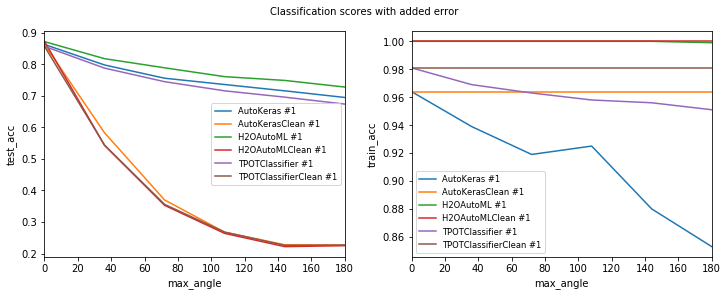

In [11]:
print_results_by_model(df,
    ["train_labels", "test_labels"],
    # ["mean", "min_val", "max_val", "train_labels", "test_labels"], 
    err_param_name="max_angle",
    # err_param_name="std",
    pipeline_name="best_pipeline"
)
visualize(df)